# Lesson 06 — Support Vector Machines (CS229-style)

This lesson rebuilds **linear soft-margin SVMs** from first principles, exactly in the spirit of CS229:

**What you will implement (NumPy-only):**
- Hinge loss + $L_2$ regularization (primal objective)
- **Batch subgradient descent** (transparent, easy to debug)
- **Pegasos (stochastic subgradient)** as a practical alternative
- Diagnostics: objective, margin violations, support vectors, stability checks

**What you will visualize (pedagogical, geometry-first):**
- 2D **confidence surface** (a sigmoid of the SVM score, used only for visualization)
- Decision boundary and **margin lines**
- Support vectors highlighted
- Errors marked with **X/O** markers (wrong vs correct)
- A **3D “extruded wall”**: the 2D decision boundary lifted vertically (per the rules)

---

## Goals

By the end you should be able to answer:

1. Why does maximizing margin improve generalization?
2. What does the hinge loss actually do point-by-point?
3. How do $\\lambda$ (regularization) and step size change the solution?
4. How do SVM geometry and logistic regression geometry differ?
5. What diagnostics tell you when training is failing?



In [15]:
import numpy as np
import matplotlib.pyplot as plt

# datasets only (allowed)
from sklearn.datasets import make_blobs, make_classification

np.random.seed(0)


## 1) A clean 2D dataset for geometry

SVM geometry is easiest to understand in **2D**, so we will start there.

We will create a binary dataset with some overlap so that:
- hard-margin separation is impossible,
- the **soft-margin** trade-off matters,
- support vectors are visible.

We will also later show a high-dimensional dataset briefly (no heavy visuals there).


In [16]:
def make_2d_overlap(n=350, seed=0):
    rng = np.random.default_rng(seed)
    X, y01 = make_blobs(
        n_samples=n,
        centers=[(-1.2, -0.6), (1.0, 0.8)],
        cluster_std=[1.05, 1.00],
        random_state=seed
    )
    # map {0,1} -> {-1,+1}
    y = np.where(y01 == 0, -1, 1)

    # standardize (important for margin geometry + stable optimization)
    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-12)
    return X, y

X2, y2 = make_2d_overlap(n=450, seed=0)
m2 = X2.shape[0]

# add bias
X2b = np.hstack([np.ones((m2, 1)), X2])

print("2D dataset:", X2.shape, "labels:", np.unique(y2))


2D dataset: (450, 2) labels: [-1  1]


### Plot the raw data (true labels only)

- Color = true label (red/blue)
- No model predictions yet


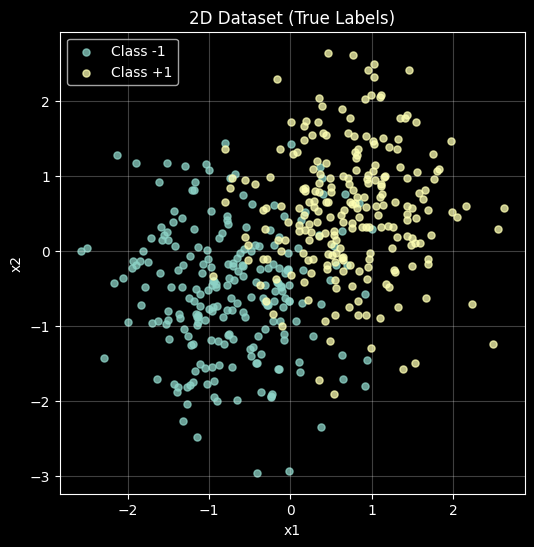

In [17]:
def plot_points_only(X, y, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[y==-1, 0], X[y==-1, 1], s=26, alpha=0.75, label="Class -1")
    plt.scatter(X[y==+1, 0], X[y==+1, 1], s=26, alpha=0.75, label="Class +1")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.show()

plot_points_only(X2, y2, "2D Dataset (True Labels)")


## 2) SVM objective, hinge loss, and the margin

We will use the **soft-margin primal** objective:

$$
J(\\theta) = \\frac{1}{m} \\sum_{i=1}^m \\max\\bigl(0, 1 - y^{(i)} (\\theta^T \\tilde{x}^{(i)})\\bigr)
+ \\frac{\\lambda}{2}\\|\\theta\\|_2^2
$$

- $\\tilde{x}$ includes the bias term (a leading 1).
- The **score** is $f(x)=\\theta^T\\tilde{x}$.
- The **margin** for a point is $y f(x)$.

**Key geometric facts**
- The decision boundary is $f(x)=0$.
- The SVM constraints (in the canonical scaling) are $y f(x) \\ge 1$.
- The margin “rails” are $f(x)=+1$ and $f(x)=-1$ (same scale as hinge loss).

**Pointwise behavior**
- If $y f(x) \\ge 1$: hinge loss is 0 (already safely on the correct side with margin).
- If $0 < y f(x) < 1$: correct side but “too close” → penalty.
- If $y f(x) \\le 0$: misclassified → penalty grows linearly.

We will train $\\theta$ by **subgradient descent**, because hinge loss is not differentiable at $y f(x)=1$.


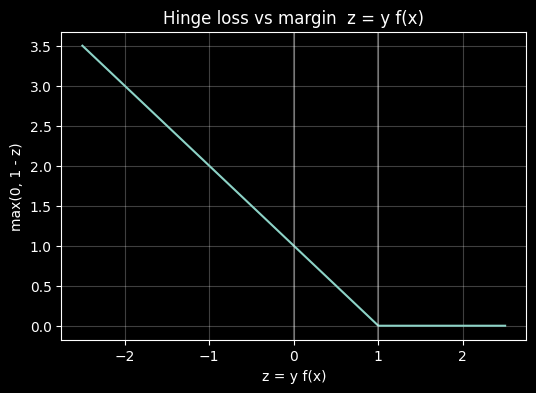

In [18]:
def hinge(z):
    return np.maximum(0.0, 1.0 - z)

zs = np.linspace(-2.5, 2.5, 400)
plt.figure(figsize=(6,4))
plt.plot(zs, hinge(zs))
plt.axvline(0, alpha=0.3)
plt.axvline(1, alpha=0.3)
plt.title("Hinge loss vs margin  z = y f(x)")
plt.xlabel("z = y f(x)")
plt.ylabel("max(0, 1 - z)")
plt.grid(alpha=0.25)
plt.show()


## 3) Minimal SVM implementation (NumPy)

We implement **batch subgradient descent** for transparency.

Let $M_i = y^{(i)} (\\theta^T \\tilde{x}^{(i)})$ be margins.  
Define the violating set $\\mathcal{V} = \\{ i : M_i < 1 \\}$.

A valid subgradient is:

$$
\nabla_\theta J
=
-\frac{1}{m}\sum_{i\\in\mathcal{V}} y^{(i)}\tilde{x}^{(i)}
+ \lambda \theta
$$

We will also record diagnostics each epoch:
- objective value
- fraction violating the margin
- $\\|\\theta\\|_2$


In [19]:
def svm_objective(Xb, y, theta, lambda_):
    # theta shape: (d,)
    margins = y * (Xb @ theta)
    loss = hinge(margins).mean()
    reg = 0.5 * lambda_ * np.sum(theta**2)
    return loss + reg

def svm_subgradient(Xb, y, theta, lambda_):
    m = Xb.shape[0]
    margins = y * (Xb @ theta)
    mask = margins < 1.0
    grad = np.zeros_like(theta)
    if np.any(mask):
        grad = -(Xb[mask].T @ y[mask]) / m
    grad += lambda_ * theta
    return grad

def train_svm_batch_subgrad(Xb, y, lambda_=0.01, lr=0.1, epochs=400):
    theta = np.zeros(Xb.shape[1], dtype=np.float64)
    hist = {
        "obj": [],
        "viol_frac": [],
        "theta_norm": [],
    }
    for ep in range(epochs):
        obj = svm_objective(Xb, y, theta, lambda_)
        margins = y * (Xb @ theta)
        viol_frac = np.mean(margins < 1.0)

        hist["obj"].append(obj)
        hist["viol_frac"].append(viol_frac)
        hist["theta_norm"].append(np.linalg.norm(theta))

        grad = svm_subgradient(Xb, y, theta, lambda_)
        theta = theta - lr * grad

    return theta, hist

def predict_svm(Xb, theta):
    return np.where((Xb @ theta) >= 0.0, 1, -1)


## 4) Train on the 2D dataset + diagnostics

We start with a reasonable pair of hyperparameters and then explore how changing $\\lambda$ affects:
- margin width (via $\\|w\\|$)
- number of support vectors
- training errors

**Note:** Step size matters a lot for subgradient descent.  
If objective explodes or oscillates wildly, reduce `lr` (and/or increase $\\lambda$).


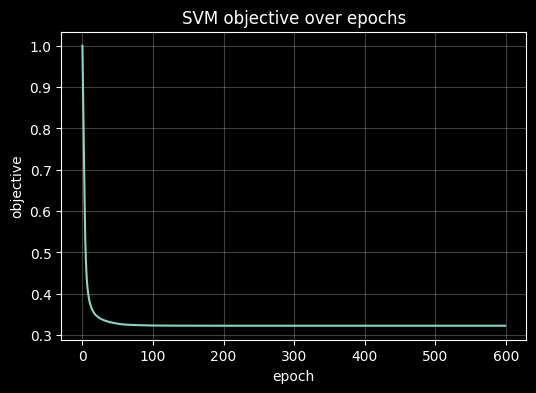

In [31]:
lambda_ = 0.03
lr = 0.15
epochs = 600

theta_svm, hist = train_svm_batch_subgrad(X2b, y2, lambda_=lambda_, lr=lr, epochs=epochs)

pred = predict_svm(X2b, theta_svm)
acc = np.mean(pred == y2)

print("theta:", theta_svm)
print(f"train acc: {acc:.3f}")
print(f"final obj: {hist['obj'][-1]:.4f} | viol frac: {hist['viol_frac'][-1]:.3f} | ||theta||: {hist['theta_norm'][-1]:.3f}")

# Plot diagnostics
plt.figure(figsize=(6,4))
plt.plot(hist["obj"])
plt.title("SVM objective over epochs")
plt.xlabel("epoch")
plt.ylabel("objective")
plt.grid(alpha=0.25)
plt.show()


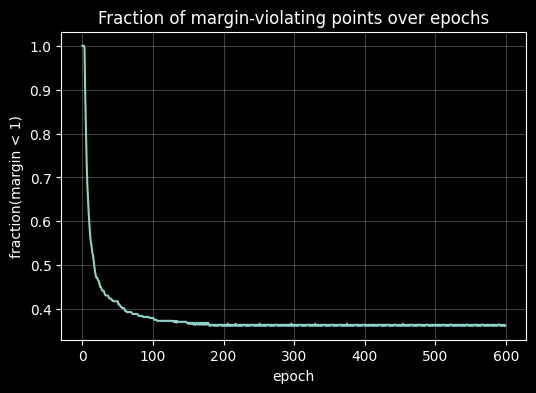

In [30]:
plt.figure(figsize=(6,4))
plt.plot(hist["viol_frac"])
plt.title("Fraction of margin-violating points over epochs")
plt.xlabel("epoch")
plt.ylabel("fraction(margin < 1)")
plt.grid(alpha=0.25)
plt.show()

## 5) High-quality 2D visualizations (CS229 geometry)

### Important note on “probability”
A linear SVM does **not** output probabilities by default.  
However, for a **pedagogical background surface**, we can map the signed score $f(x)$ through a sigmoid:

$$
p_\text{viz}(y=1\mid x) = \sigma(k f(x))
$$

This is **only** a visualization of confidence-like monotonic behavior, not a calibrated probability.

### What we will show
- Background = $p_\text{viz}(y=1\mid x)$ with a colorbar
- Decision boundary at $p_\text{viz}=0.5$ (equivalently $f(x)=0$)
- Margin lines at $f(x)=\pm 1$
- True labels = color (red/blue)
- Wrong predictions = **X marker**
- Correct predictions = **O marker**
- Support vectors (approximately) = points with $y f(x) \\le 1 + \\epsilon$


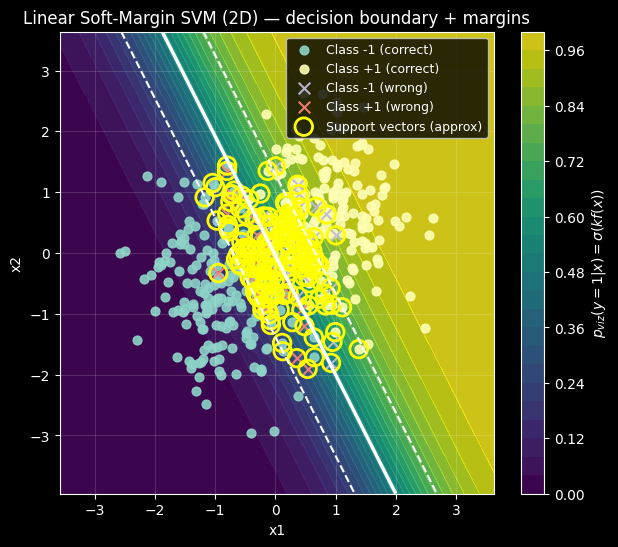

In [21]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

ACTIONS = None  # placeholder for later lessons; here it's irrelevant.

def svm_score_grid(theta, xx, yy):
    # theta = [b, w1, w2]
    grid = np.c_[np.ones(xx.size), xx.ravel(), yy.ravel()]
    scores = grid @ theta
    return scores.reshape(xx.shape)

def plot_svm_2d(X, y, theta, title, k_viz=1.0, sv_eps=1e-2):
    # Grid
    x_min, x_max = X[:,0].min() - 1.0, X[:,0].max() + 1.0
    y_min, y_max = X[:,1].min() - 1.0, X[:,1].max() + 1.0
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 350),
        np.linspace(y_min, y_max, 350),
    )

    scores = svm_score_grid(theta, xx, yy)
    pviz = sigmoid(k_viz * scores)

    # Predictions on training points
    Xb = np.hstack([np.ones((X.shape[0],1)), X])
    scores_pts = Xb @ theta
    yhat = np.where(scores_pts >= 0.0, 1, -1)

    # Support vectors (approx): y f(x) <= 1 + eps
    margins = y * scores_pts
    sv_mask = margins <= (1.0 + sv_eps)

    # Plot
    plt.figure(figsize=(7,6))
    im = plt.contourf(xx, yy, pviz, levels=30, alpha=0.85)
    plt.colorbar(im, label=r"$p_{viz}(y=1|x)=\sigma(k f(x))$")

    # decision boundary and margin lines in score space
    plt.contour(xx, yy, scores, levels=[0.0], linewidths=2.5, colors="white")
    plt.contour(xx, yy, scores, levels=[-1.0, +1.0], linewidths=1.5, colors="white", linestyles="--")

    # Points: true label color
    # Marker: O correct, X wrong
    correct = (yhat == y)

    plt.scatter(X[(y==-1) & correct, 0], X[(y==-1) & correct, 1], s=40, alpha=0.9, marker="o", label="Class -1 (correct)")
    plt.scatter(X[(y==+1) & correct, 0], X[(y==+1) & correct, 1], s=40, alpha=0.9, marker="o", label="Class +1 (correct)")

    plt.scatter(X[(y==-1) & (~correct), 0], X[(y==-1) & (~correct), 1], s=70, alpha=0.95, marker="x", label="Class -1 (wrong)")
    plt.scatter(X[(y==+1) & (~correct), 0], X[(y==+1) & (~correct), 1], s=70, alpha=0.95, marker="x", label="Class +1 (wrong)")

    # Support vectors highlighted with rings
    plt.scatter(X[sv_mask, 0], X[sv_mask, 1], s=160, facecolors="none", edgecolors="yellow", linewidths=2.0, label="Support vectors (approx)")

    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend(loc="upper right", fontsize=9)
    plt.grid(alpha=0.15)
    plt.show()

plot_svm_2d(X2, y2, theta_svm, "Linear Soft-Margin SVM (2D) — decision boundary + margins", k_viz=1.2)


### Margin width intuition

For the canonical scaling of the SVM constraints, margin lines are $f(x)=\\pm 1$.

If $w$ is the weight vector (excluding bias), the geometric margin width is:

$$
\\text{margin width} = \\frac{2}{\\|w\\|}
$$

So when regularization changes $\\|w\\|$, it changes the margin width.


In [22]:
w = theta_svm[1:]
margin_width = 2.0 / (np.linalg.norm(w) + 1e-12)
print("||w||:", np.linalg.norm(w))
print("geometric margin width ~ 2/||w||:", margin_width)


||w||: 1.647009770070312
geometric margin width ~ 2/||w||: 1.2143218797745228


## 6) How $\\lambda$ changes the solution (soft-margin trade-off)

We train multiple SVMs to see the effect:
- smaller $\\lambda$ → weaker regularization → larger weights → narrower margin (can fit harder)
- larger $\\lambda$ → stronger regularization → smaller weights → wider margin (may underfit)

We will keep the training procedure fixed to isolate the effect of $\\lambda$.


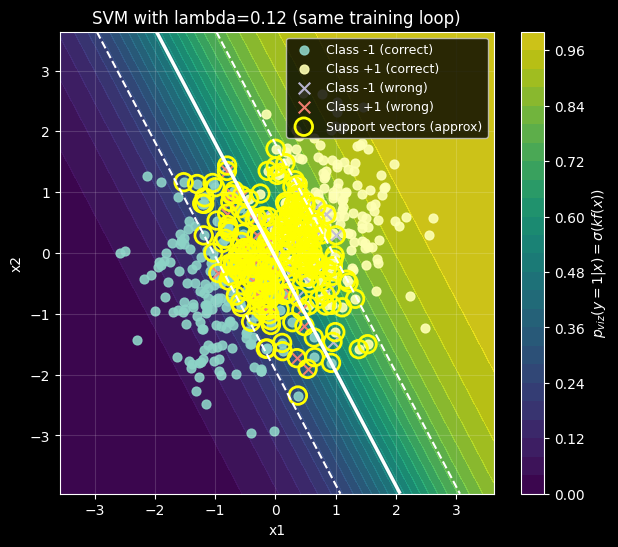

In [23]:
lambdas = [0.005, 0.03, 0.12]
thetas = []
for lam in lambdas:
    th, h = train_svm_batch_subgrad(X2b, y2, lambda_=lam, lr=0.12, epochs=650)
    thetas.append(th)
    acc = np.mean(predict_svm(X2b, th) == y2)
    w = th[1:]
    print(f"lambda={lam:>6} | acc={acc:.3f} | ||w||={np.linalg.norm(w):.3f} | margin~{2/(np.linalg.norm(w)+1e-12):.3f}")

for lam, th in zip(lambdas, thetas):
    plot_svm_2d(X2, y2, th, f"SVM with lambda={lam} (same training loop)", k_viz=1.2)


## 7) Logistic regression comparison
SVM and logistic regression can produce similar decision boundaries, but their losses behave differently.

Logistic regression minimizes:

$$
J(\theta)=\frac{1}{m}\sum_i \log\left(1 + \exp\left(-y^{(i)}\theta^T\tilde{x}^{(i)}\right)\right) + \frac{\lambda}{2}\|\theta\|^2
$$

Key difference:
- logistic loss keeps penalizing even confidently correct points (though exponentially less),
- hinge loss becomes exactly 0 once margin exceeds 1.

We will train a logistic reg model and plot its probability surface alongside SVM’s score-surface.


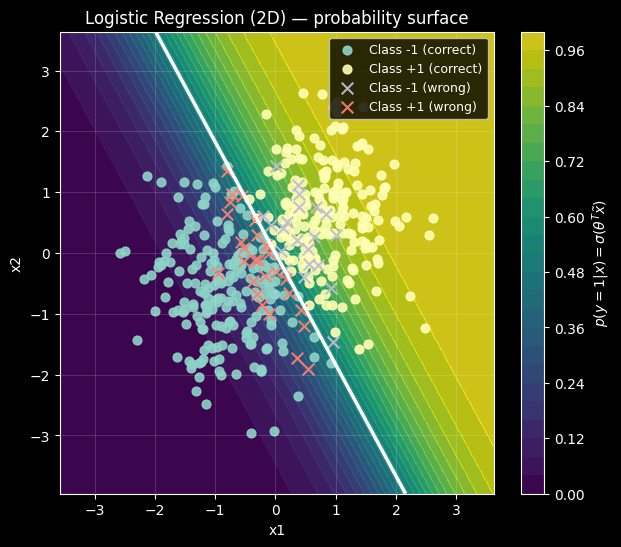

In [29]:
def logistic_loss_and_grad(Xb, y, theta, lambda_):
    # y in {-1,+1}
    z = y * (Xb @ theta)
    # loss: log(1+exp(-z))
    loss = np.log1p(np.exp(-z)).mean() + 0.5*lambda_*np.sum(theta**2)
    # gradient
    # d/dtheta log(1+exp(-z)) = -(y x) * sigmoid(-z)
    s = sigmoid(-z)
    grad = -(Xb.T @ (y * s)) / Xb.shape[0] + lambda_*theta
    return loss, grad

def train_logreg(Xb, y, lambda_=0.03, lr=0.2, epochs=800):
    theta = np.zeros(Xb.shape[1], dtype=np.float64)
    hist = []
    for _ in range(epochs):
        loss, grad = logistic_loss_and_grad(Xb, y, theta, lambda_)
        hist.append(loss)
        theta -= lr * grad
    return theta, np.array(hist)

theta_lr, hist_lr = train_logreg(X2b, y2, lambda_=0.03, lr=0.25, epochs=900)
pred_lr = np.where((X2b @ theta_lr) >= 0, 1, -1)
acc_lr = np.mean(pred_lr == y2)
print("logreg acc:", acc_lr)

plt.figure(figsize=(6,4))
plt.plot(hist_lr)
plt.title("Logistic regression objective over epochs")
plt.xlabel("epoch")
plt.ylabel("objective")
plt.grid(alpha=0.25)
plt.show()

def plot_logreg_2d(X, y, theta, title):
    x_min, x_max = X[:,0].min() - 1.0, X[:,0].max() + 1.0
    y_min, y_max = X[:,1].min() - 1.0, X[:,1].max() + 1.0
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 350),
        np.linspace(y_min, y_max, 350),
    )
    grid = np.c_[np.ones(xx.size), xx.ravel(), yy.ravel()]
    scores = grid @ theta
    probs = sigmoid(scores).reshape(xx.shape)

    Xb = np.hstack([np.ones((X.shape[0],1)), X])
    p_pts = sigmoid(Xb @ theta)
    yhat = np.where(p_pts >= 0.5, 1, -1)
    correct = (yhat == y)

    plt.figure(figsize=(7,6))
    im = plt.contourf(xx, yy, probs, levels=30, alpha=0.85)
    plt.colorbar(im, label=r"$p(y=1|x)=\sigma(\theta^T\tilde{x})$")
    plt.contour(xx, yy, probs, levels=[0.5], linewidths=2.5, colors="white")

    plt.scatter(X[(y==-1) & correct, 0], X[(y==-1) & correct, 1], s=40, alpha=0.9, marker="o", label="Class -1 (correct)")
    plt.scatter(X[(y==+1) & correct, 0], X[(y==+1) & correct, 1], s=40, alpha=0.9, marker="o", label="Class +1 (correct)")

    plt.scatter(X[(y==-1) & (~correct), 0], X[(y==-1) & (~correct), 1], s=70, alpha=0.95, marker="x", label="Class -1 (wrong)")
    plt.scatter(X[(y==+1) & (~correct), 0], X[(y==+1) & (~correct), 1], s=70, alpha=0.95, marker="x", label="Class +1 (wrong)")

    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend(loc="upper right", fontsize=9)
    plt.grid(alpha=0.15)
    plt.show()

plot_logreg_2d(X2, y2, theta_lr, "Logistic Regression (2D) — probability surface")


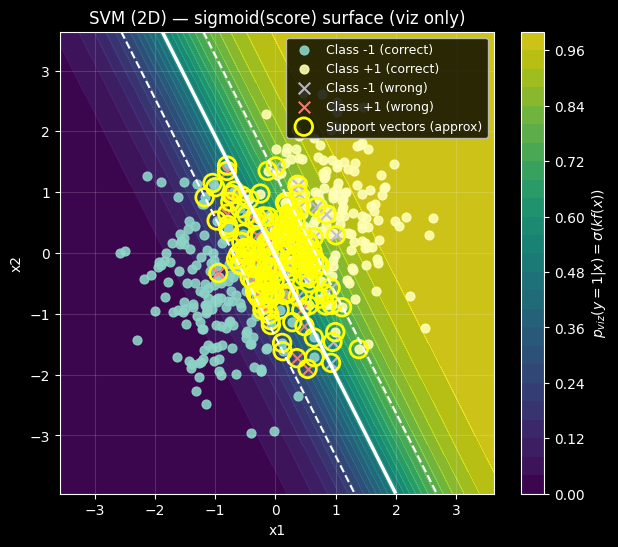

In [28]:
plot_svm_2d(X2, y2, theta_svm, "SVM (2D) — sigmoid(score) surface (viz only)", k_viz=1.2)

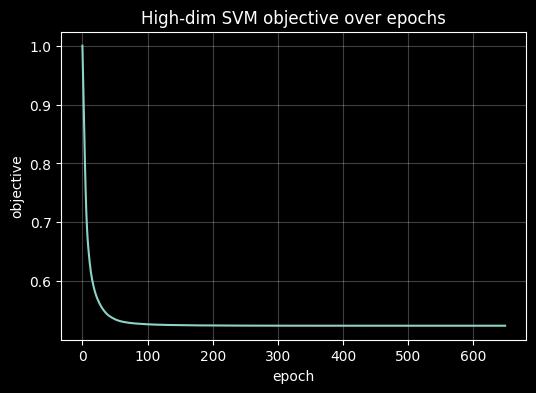

In [27]:
Xh, yh01 = make_classification(
    n_samples=900,
    n_features=30,
    n_informative=10,
    n_redundant=5,
    class_sep=1.0,
    flip_y=0.05,
    random_state=0
)
yh = np.where(yh01 == 0, -1, 1)

# standardize
Xh = (Xh - Xh.mean(axis=0)) / (Xh.std(axis=0) + 1e-12)
Xhb = np.hstack([np.ones((Xh.shape[0],1)), Xh])

theta_h, hist_h = train_svm_batch_subgrad(Xhb, yh, lambda_=0.05, lr=0.08, epochs=650)
acc_h = np.mean(predict_svm(Xhb, theta_h) == yh)

print("High-dim train acc:", acc_h)

plt.figure(figsize=(6,4))
plt.plot(hist_h["obj"])
plt.title("High-dim SVM objective over epochs")
plt.xlabel("epoch")
plt.ylabel("objective")
plt.grid(alpha=0.25)
plt.show()


## 9) Key Takeaways (Lesson 06) —

### When to use a linear SVM
- When you need a **strong linear baseline** with good generalization.
- When you care about **margin** as a robustness concept.
- When features are moderately high-dimensional and you expect near-linear separation.
- When you want a classifier that depends strongly on a **subset** of critical points (support vectors).

### What the algorithm is actually doing
- The hinge loss is a **piecewise-linear penalty** in the margin $y f(x)$.
- Points with $y f(x) \\ge 1$ contribute **zero** hinge loss.
- The solution is shaped primarily by:
  - points on the margin ($y f(x) \\approx 1$),
  - and misclassified / near-boundary points ($y f(x) < 1$).
- These are the **support vectors**, and they dominate the learned boundary.

### Failure modes
1. **Bad feature scaling**
   - If features are not standardized, the margin geometry is distorted.
   - Optimization becomes unstable; one feature can dominate simply by scale.
2. **Learning rate issues (subgradient descent)**
   - Too large → objective oscillates or explodes.
   - Too small → extremely slow progress; boundary looks underfit.
3. **Regularization mismatch**
   - $\\lambda$ too small → large weights → narrow margin → overfitting / sensitivity to noise.
   - $\\lambda$ too large → small weights → wide margin → underfitting.
4. **Non-separable structure**
   - If the true boundary is nonlinear (XOR-style), a linear SVM will fail systematically.
   - You either need feature engineering or a kernel method (later lesson).

### Bias–variance behavior
- Increasing $\\lambda$ increases bias (simpler boundary, wider margin).
- Decreasing $\\lambda$ increases variance (more sensitive boundary, narrower margin).
- SVMs often have a good bias–variance trade because margin maximization is an implicit regularizer.

### Practical diagnostics you should always check
- **Objective curve**: should decrease and stabilize (not necessarily smooth).
- **Margin violation fraction**: should drop, then flatten.
- **Support vector fraction**:
  - very high fraction can indicate:
    - heavy overlap / noisy labels,
    - too much regularization,
    - or a fundamentally non-separable problem.
- **Weight norm** $\\|w\\|$:
  - large norm means narrow margin; check for overfitting.
- **Confusion patterns** (even on training data):
  - systematic errors often mean “linear model mismatch,” not optimization failure.

### Geometry connections to later lessons
- The “wall” visualization is the simplest geometric picture of classification:
  - SVM uses the sign of a score function $f(x)$.
  - Later, neural nets learn highly flexible $f(x)$.
- The concept of **support vectors** foreshadows sparse dependence on examples:
  - kernel SVM depends on support vectors through the dual.
- The margin viewpoint connects to robustness and generalization:
  - later regularization ideas (early stopping, weight decay) are margin-adjacent.

### Connection to logistic regression
- Both can learn similar boundaries in many datasets.
- Logistic regression produces **probabilities** (after training), SVM does not inherently.
- SVM’s hinge loss becomes exactly 0 past margin 1; logistic loss keeps penalizing but diminishes.
- If you need calibrated probabilities, logistic regression is often preferred.
- If you need a strong margin-based boundary, SVM is often preferred.

### If your SVM looks wrong
1. Re-check label encoding is exactly $\\{-1,+1\\}$.
2. Standardize features.
3. Lower learning rate and re-run.
4. Increase $\\lambda$ if weights explode or boundary becomes jagged.
5. Plot margin violations and support vectors to see if the dataset is inherently overlapping.

